# Trabalho Final: Identificação e Rastreamento de Trilhas em PCB

**Alunos:** Gabriel Batista Barbosa // Luan Almeida Valença
**Disciplina:** Processamento de Imagens

## Resumo
Este notebook apresenta uma solução para a identificação de conexões elétricas em imagens de Placas de Circuito Impresso (PCB). O algoritmo realiza:
1.  Binarização da imagem.
2.  Separação morfológica entre Pads (ilhas de solda) e Trilhas.
3.  Rotulagem e ordenação dos Pads (Top-Left -> Bottom-Right).
4.  Esqueletização e poda das trilhas.
5.  Análise de conectividade para gerar o netlist (X <-> Y).

## Bibliotecas Utilizadas
* **NumPy:** Manipulação matricial.
* **Matplotlib:** Leitura e visualização.
* **Scikit-Image (skimage):** Implementações de algoritmos vistos em aula (Morfologia, Limiarização, Skeletonização).

In [70]:
import numpy as np
import matplotlib.pyplot as plt
import os
from skimage import io, color, filters, morphology, measure
from skimage.util import img_as_bool

# Função simples para agilizar a exibição de imagens
def show_steps(images, titles, cmap='gray'):
    n = len(images)
    fig, axes = plt.subplots(1, n, figsize=(5 * n, 5))
    if n == 1: axes = [axes]
    
    for ax, img, title in zip(axes, images, titles):
        ax.imshow(img, cmap=cmap)
        ax.set_title(title)
        ax.axis('off')
    plt.tight_layout()
    plt.show()

print("Bibliotecas importadas.")

Bibliotecas importadas.


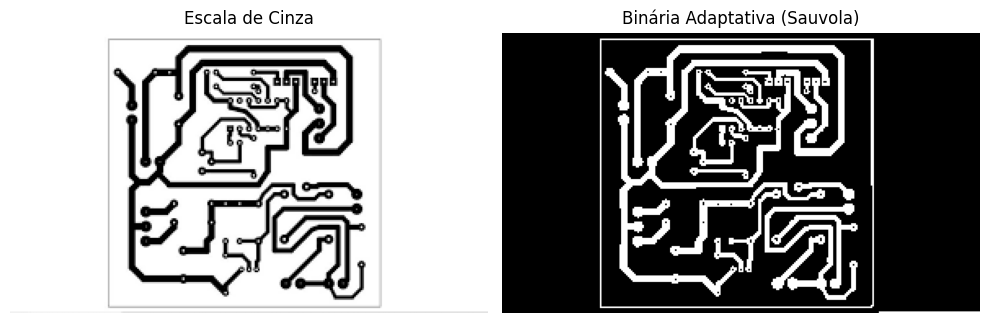

In [71]:
# --- CONFIGURAÇÃO ---
PASTA_IMAGENS = 'Imagens'
NOME_ARQUIVO = 'img3.png' # Troque pelo seu arquivo atual
caminho_completo = os.path.join(PASTA_IMAGENS, NOME_ARQUIVO)

# 1. Carregamento
try:
    img_original = io.imread(caminho_completo)
except FileNotFoundError:
    print(f"ERRO: Imagem '{NOME_ARQUIVO}' não encontrada.")
    img_original = np.zeros((100, 100), dtype=np.uint8)

# 2. Tratamento de Canais (RGBA -> RGB -> Gray)
if img_original.ndim == 3:
    if img_original.shape[2] == 4:
        img_rgb = color.rgba2rgb(img_original)
        img_gray = color.rgb2gray(img_rgb)
    else:
        img_gray = color.rgb2gray(img_original)
else:
    img_gray = img_original

# 3. Binarização ADAPTATIVA (Sauvola) - O Segredo da Separação
# window_size: Tamanho da janela local. 25px costuma ser bom para PCBs.
# k: Sensibilidade (0.2 a 0.5). Quanto maior, mais fina fica a trilha.
thresh_sauvola = filters.threshold_sauvola(img_gray, window_size=25, k=0.1) 
img_binary = img_gray > thresh_sauvola

# 4. Verificação de Polaridade
# Garantir que Fundo=Preto (False) e Trilhas=Branco (True)
if np.sum(img_binary) > (img_binary.size / 2):
    img_binary = ~img_binary

# REMOVIDO: morphology.binary_closing(img_binary)
# Motivo: O "Closing" dilatava as trilhas e causava o curto-circuito. 
# Agora usamos a imagem "crua" e nítida do Sauvola.

# Função auxiliar de plotagem
def show_steps(images, titles):
    fig, axes = plt.subplots(1, len(images), figsize=(5 * len(images), 5))
    if len(images) == 1: axes = [axes]
    for ax, img, title in zip(axes, images, titles):
        ax.imshow(img, cmap='gray')
        ax.set_title(title)
        ax.axis('off')
    plt.tight_layout()
    plt.show()

show_steps([img_gray, img_binary], 
           ['Escala de Cinza', 'Binária Adaptativa (Sauvola)'])

C:\Users\Luan\AppData\Local\Temp\ipykernel_18804\1192963380.py:11: FutureWarning: Parameter `area_threshold` is deprecated since version 0.26.0 and will be removed in 2.0.0 (or later). To avoid this warning, please use the parameter `max_size` instead. For more details, see the documentation of `remove_small_holes`. Note that the new threshold removes objects smaller than **or equal to** its value, while the previous parameter only removed smaller ones.
  img_filled = remove_small_holes(img_bool, area_threshold=200)
C:\Users\Luan\AppData\Local\Temp\ipykernel_18804\1192963380.py:16: FutureWarning: `binary_opening` is deprecated since version 0.26 and will be removed in version 0.28. Use `skimage.morphology.opening` instead.
  img_pads_isolated = morphology.binary_opening(img_filled, morphology.disk(3))
C:\Users\Luan\AppData\Local\Temp\ipykernel_18804\1192963380.py:21: FutureWarning: `binary_erosion` is deprecated since version 0.26 and will be removed in version 0.28. Use `skimage.morph

--- Relatório Final ---
Pads Aceitos: 1
Objetos Rejeitados (Trilhas/Ruído): 12


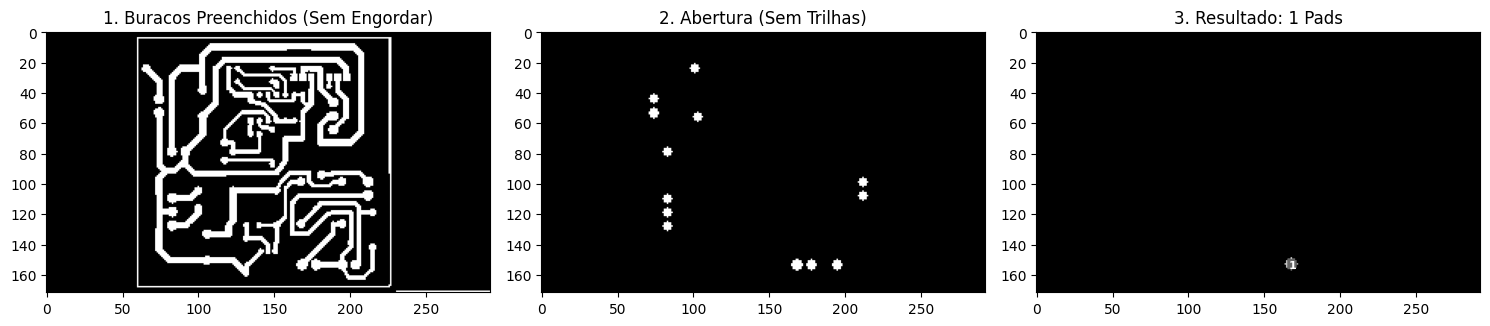

In [72]:
# Célula 4: Detecção por Preenchimento de Área (Sem Dilatação)

# 1. Tapa-Buracos Inteligente
# Em vez de fechar (que engorda e gruda pads), usamos remove_small_holes.
# Ela localiza buracos pretos cercados de branco e os pinta de branco.
# area_threshold=200 garante que furos de pads (e até o "C" quebrado) sejam preenchidos.
from skimage.morphology import remove_small_holes

# Precisamos garantir que seja bool para essa função
img_bool = img_binary.astype(bool)
img_filled = remove_small_holes(img_bool, area_threshold=200)

# 2. Abertura para remover Trilhas
# Agora que os pads são sólidos e NÃO cresceram, podemos ser cirúrgicos.
# disk(3) remove as trilhas finas.
img_pads_isolated = morphology.binary_opening(img_filled, morphology.disk(3))

# 3. Separação Leve (Erosão Suave)
# Como não engordamos os pads, eles não devem estar muito grudados.
# Uma erosão leve (disk 1 ou 2) é suficiente para garantir separação de toques sutis.
img_separated = morphology.binary_erosion(img_pads_isolated, morphology.disk(1))

# 4. Rotulagem
label_pads = measure.label(img_separated)
props = measure.regionprops(label_pads)

pads_metadata = []

# Parâmetros de Filtro
MIN_AREA = 20      # Ruído
MAX_ECCENTRICITY = 0.90 # Formato (Círculos/Quadrados = ok, Trilhas = ruim)

print("--- Relatório Final ---")
count_rejected = 0

for prop in props:
    # Lógica de Aceite
    if prop.area > MIN_AREA:
        if prop.eccentricity < MAX_ECCENTRICITY:
            y, x = prop.centroid
            pads_metadata.append({'y': y, 'x': x})
        else:
            # print(f"Rejeitado por forma (trilha): Label {prop.label}")
            count_rejected += 1
    else:
        count_rejected += 1

print(f"Pads Aceitos: {len(pads_metadata)}")
print(f"Objetos Rejeitados (Trilhas/Ruído): {count_rejected}")

# 5. Ordenação
pads_metadata.sort(key=lambda k: (int(k['y'] // 15), k['x']))

# 6. Reconstrução Visual
pads_labeled_map = np.zeros_like(label_pads, dtype=int)
final_pads_list = []

# Recriar os discos visualmente para ficar bonito na imagem
for i, data in enumerate(pads_metadata):
    # Desenhamos um disco de tamanho fixo no local encontrado
    rr, cc = morphology.disk(4).shape
    yc, xc = int(data['y']), int(data['x'])
    
    rr_idx, cc_idx = morphology.disk(4).nonzero()
    rr_idx = rr_idx - 4 + yc
    cc_idx = cc_idx - 4 + xc
    
    valid = (rr_idx >= 0) & (rr_idx < img_binary.shape[0]) & \
            (cc_idx >= 0) & (cc_idx < img_binary.shape[1])
    
    pads_labeled_map[rr_idx[valid], cc_idx[valid]] = i + 1
    data['id'] = i + 1
    final_pads_list.append(data)

# VISUALIZAÇÃO
fig, ax = plt.subplots(1, 3, figsize=(15, 5))

ax[0].imshow(img_filled, cmap='gray')
ax[0].set_title('1. Buracos Preenchidos (Sem Engordar)')

ax[1].imshow(img_pads_isolated, cmap='gray')
ax[1].set_title('2. Abertura (Sem Trilhas)')

ax[2].imshow(pads_labeled_map, cmap='nipy_spectral')
ax[2].set_title(f'3. Resultado: {len(final_pads_list)} Pads')

for pad in final_pads_list:
    ax[2].text(pad['x'], pad['y'], str(pad['id']), 
               color='white', fontsize=8, fontweight='bold', 
               ha='center', va='center', 
               bbox=dict(facecolor='black', alpha=0.5, edgecolor='none', boxstyle='round,pad=0.1'))

plt.tight_layout()
plt.show()

pads_metadata = final_pads_list

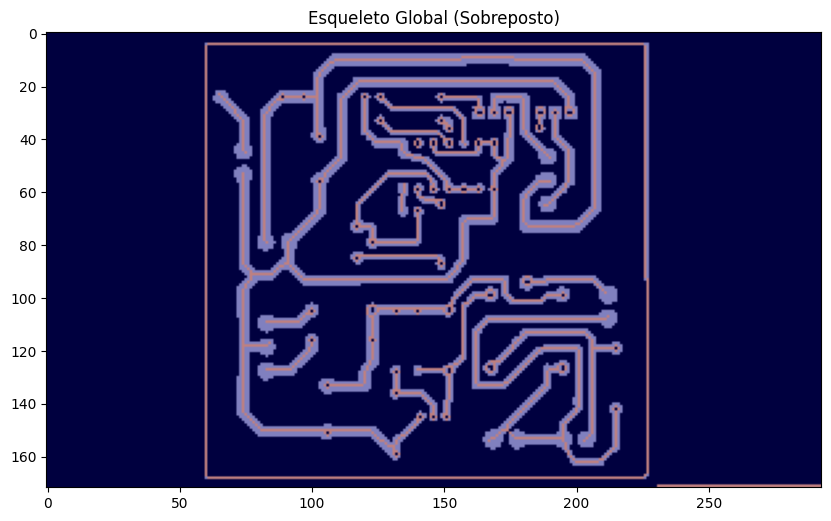


=== RESULTADO FINAL (NETLIST) ===
Ainda não encontrou conexões. Verifique se o esqueleto está contínuo na visualização acima.


C:\Users\Luan\AppData\Local\Temp\ipykernel_18804\1618742076.py:22: FutureWarning: `binary_dilation` is deprecated since version 0.26 and will be removed in version 0.28. Use `skimage.morphology.dilation` instead. Note the lack of mirroring for non-symmetric footprints (see docstring notes).
  pads_dilated = morphology.binary_dilation(pads_labeled_map > 0, morphology.disk(2))


In [73]:
# 1. Esqueletizar a imagem COMPLETA (Trilhas + Pads juntos)
# Isso garante que não haverá desconexão entre pad e trilha
skeleton_global = morphology.skeletonize(img_binary)

# 2. Rotular os "Fios" do esqueleto
# connectivity=2 permite conexões na diagonal (importante para esqueletos)
skeleton_labeled = measure.label(skeleton_global, connectivity=2)
skeleton_props = measure.regionprops(skeleton_labeled)

# Visualizar o esqueleto sobre a imagem original para confirmar
plt.figure(figsize=(10,10))
plt.imshow(img_binary, cmap='gray')
plt.imshow(skeleton_global, cmap='jet', alpha=0.5) # Esqueleto em cor
plt.title("Esqueleto Global (Sobreposto)")
plt.show()

# 3. Cruzamento: Quem toca quem?
# Dicionário: Chave = ID do Fio (Esqueleto), Valor = Lista de IDs de Pads que ele toca
connections = {}

# Dilatamos levemente os Pads identificados para garantir que o esqueleto "toque" neles
pads_dilated = morphology.binary_dilation(pads_labeled_map > 0, morphology.disk(2))
# Recuperamos os IDs na versão dilatada (usando multiplicação pela imagem original de labels seria ideal, 
# mas vamos usar vizinhança direta)

# ITERAÇÃO INTELIGENTE
# Vamos percorrer cada Pad e ver qual Fio (label do esqueleto) passa por dentro dele.
for pad_info in pads_metadata:
    pad_id = pad_info['id']
    yc, xc = int(pad_info['y']), int(pad_info['x'])
    
    # Criamos uma pequena janela ao redor do centro do pad
    # O esqueleto deve passar por ali
    window_size = 10
    y_min, y_max = max(0, yc - window_size), min(img_binary.shape[0], yc + window_size)
    x_min, x_max = max(0, xc - window_size), min(img_binary.shape[1], xc + window_size)
    
    # Recorte do esqueleto rotulado nessa área
    skel_crop = skeleton_labeled[y_min:y_max, x_min:x_max]
    
    # Quais fios passam aqui? (Ignorando 0 que é fundo)
    fios_presentes = np.unique(skel_crop)
    fios_presentes = fios_presentes[fios_presentes > 0]
    
    # Registra a conexão
    for fio_id in fios_presentes:
        if fio_id not in connections:
            connections[fio_id] = set()
        connections[fio_id].add(pad_id)

# 4. Gerar Netlist
netlist = []
for fio_id, pads_connected in connections.items():
    if len(pads_connected) >= 2:
        # Se um fio toca 2 ou mais pads, eles estão conectados!
        pads_list = sorted(list(pads_connected))
        
        # Gera pares combinados (Ex: se fio toca 1, 5, 8 -> 1-5, 1-8, 5-8 ou apenas linear)
        # O enunciado pede X <-> Y. Vamos listar pares.
        import itertools
        for a, b in itertools.combinations(pads_list, 2):
            netlist.append(f"{a} <-> {b}")

# Remove duplicatas e ordena
netlist = sorted(list(set(netlist)))

print("\n=== RESULTADO FINAL (NETLIST) ===")
if not netlist:
    print("Ainda não encontrou conexões. Verifique se o esqueleto está contínuo na visualização acima.")
else:
    for con in netlist:
        print(con)

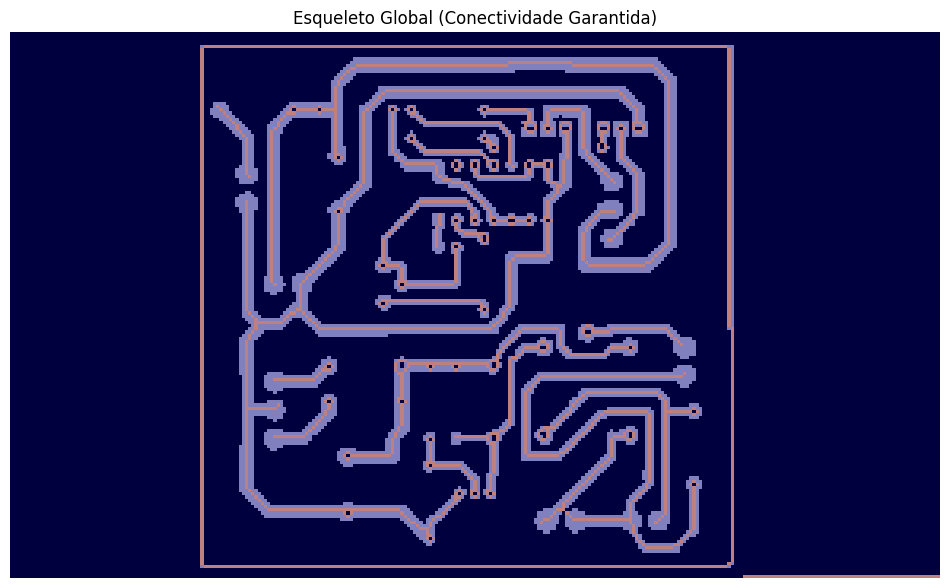

In [74]:
# Célula 6: Esqueletização Global (CORRIGIDA)
# Agora usamos a imagem binária completa para garantir continuidade dos fios.

# 1. Esqueletizar a imagem COMPLETA (Trilhas + Pads juntos)
# Isso cria um "mapa de metrô" de toda a placa
skeleton_global = morphology.skeletonize(img_binary)

# Visualizar para garantir que não tem fios quebrados
plt.figure(figsize=(12, 12))
plt.imshow(img_binary, cmap='gray')
plt.imshow(skeleton_global, cmap='jet', alpha=0.5) # Sobrepõe o esqueleto colorido
plt.title("Esqueleto Global (Conectividade Garantida)")
plt.axis('off')
plt.show()

In [75]:
# Célula 7: Lógica de Conectividade (CORRIGIDA)

# 1. Rotular os "Fios" do esqueleto (Cada linha contínua ganha um número)
skeleton_labeled = measure.label(skeleton_global, connectivity=2)

# 2. Mapeamento: Quem toca quem?
connections = {}

# Percorremos cada Pad que detectamos na Célula 4
for pad in pads_metadata:
    pad_id = pad['id']
    yc, xc = int(pad['y']), int(pad['x'])
    
    # Olhamos uma janela ao redor do centro do pad.
    # Como o esqueleto passa por dentro do pad, vamos encontrar o ID do fio ali.
    window_size = 6
    y_min, y_max = max(0, yc - window_size), min(img_binary.shape[0], yc + window_size)
    x_min, x_max = max(0, xc - window_size), min(img_binary.shape[1], xc + window_size)
    
    # Recorte do esqueleto nessa área
    skel_crop = skeleton_labeled[y_min:y_max, x_min:x_max]
    
    # Quais fios passam aqui? (Ignorando 0 que é fundo)
    fios_presentes = np.unique(skel_crop)
    fios_presentes = fios_presentes[fios_presentes > 0]
    
    # Se achou fio, anota que este fio toca neste pad
    for fio_id in fios_presentes:
        if fio_id not in connections:
            connections[fio_id] = set()
        connections[fio_id].add(pad_id)

# 3. Gerar e Imprimir a Netlist
netlist = []
for fio_id, connected_pads in connections.items():
    # Se um fio toca 2 ou mais pads, existe conexão elétrica!
    if len(connected_pads) >= 2:
        pads_sorted = sorted(list(connected_pads))
        
        # Gera os pares (X <-> Y)
        import itertools
        for a, b in itertools.combinations(pads_sorted, 2):
            netlist.append(f"{a} <-> {b}")

# Remove duplicatas e ordena final
netlist = sorted(list(set(netlist)))

print("\n=== NETLIST FINAL (Conexões Identificadas) ===")
if not netlist:
    print("Nenhuma conexão encontrada. Verifique se o esqueleto (Célula 6) passa por cima dos números dos pads (Célula 4).")
else:
    for con in netlist:
        print(con)


=== NETLIST FINAL (Conexões Identificadas) ===
Nenhuma conexão encontrada. Verifique se o esqueleto (Célula 6) passa por cima dos números dos pads (Célula 4).
